In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 12.3 MB/s 


In [ ]:
!pip install -q "tqdm>=4.36.1"

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import zipfile
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
import tqdm
import tensorflow_addons as tfa
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
import os
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import shutil
import matplotlib.pyplot as plt
import cv2 as cv2
from google.colab.patches import cv2_imshow
from keras.applications import mobilenet_v2
from tensorflow.keras.models import Sequential

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Unzip sets

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/dataset_Preprocessing_638/trainingSet.zip" -d "/content"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/dataset_Preprocessing_638/validationSet.zip" -d "/content"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/testSet.zip" -d "/content"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/testSet_clahe2.zip" -d "/content"

In [ ]:
!rm -r "/content/trainingSet/"
!rm -r "/content/testSet/"
!rm -r "/content/validationSet/"

In [ ]:
!rm -r "/content/models"

In [ ]:
os.rename("/content/testSet_divided_centered_square", "/content/testSet")

# Creation training validation and test sets

In [ ]:
BATCH_SIZE = 100
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
training_dir = PATH = '/content/trainingSet/'
validation_dir = PATH = '/content/validationSet/'

training_dataset = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)


Found 3190 files belonging to 5 classes.
Found 3510 files belonging to 5 classes.


In [ ]:
test_dir = PATH = '/content/testSet/'

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode="categorical",
  labels="inferred",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

Found 53576 files belonging to 5 classes.


In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.RandomFlip("vertical"),
  layers.RandomFlip("horizontal"),
  #layers.GaussianNoise(stddev=0.1),
  layers.RandomZoom(0.1),
  #layers.RandomTranslation(fill_mode="constant", fill_value=0.0),
  layers.RandomRotation(factor=1, fill_mode="constant", fill_value=0.0),
  ]
)

# Define conv_base

In [ ]:
conv_base = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),
    alpha=1,
    include_top= False,
    weights="imagenet",
)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

## Different feature extraction on the conv_base

### Exp 1

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                             

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
history = run_model(model, 0.00001, "SGD")

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/32           ETA: ?s - 

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 2.1611 - accuracy: 0.2323
Epoch 00001: val_loss improved from inf to 1.95988, saving model to /content/models/weights.01-1.96.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 [==============================] - 53s 1s/step - loss: 2.1611 - accuracy: 0.2323 - val_loss: 1.9599 - val_accuracy: 0.2251
Epoch 2/100


0/32           ETA: ?s - 

Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.7890 - accuracy: 0.2868
Epoch 00002: val_loss improved from 1.95988 to 1.86278, saving model to /content/models/weights.02-1.86.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.7890 - accuracy: 0.2868 - val_loss: 1.8628 - val_accuracy: 0.2590
Epoch 3/100


0/32           ETA: ?s - 

Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.6678 - accuracy: 0.3292
Epoch 00003: val_loss improved from 1.86278 to 1.84607, saving model to /content/models/weights.03-1.85.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.6678 - accuracy: 0.3292 - val_loss: 1.8461 - val_accuracy: 0.2493
Epoch 4/100


0/32           ETA: ?s - 

Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.5812 - accuracy: 0.3627
Epoch 00004: val_loss improved from 1.84607 to 1.68995, saving model to /content/models/weights.04-1.69.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.5812 - accuracy: 0.3627 - val_loss: 1.6900 - val_accuracy: 0.3048
Epoch 5/100


0/32           ETA: ?s - 

Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 1.5233 - accuracy: 0.3824
Epoch 00005: val_loss did not improve from 1.68995
32/32 [==============================] - 53s 1s/step - loss: 1.5233 - accuracy: 0.3824 - val_loss: 1.7587 - val_accuracy: 0.2795
Epoch 6/100


0/32           ETA: ?s - 

Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 1.4733 - accuracy: 0.3956
Epoch 00006: val_loss improved from 1.68995 to 1.55780, saving model to /content/models/weights.06-1.56.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.4733 - accuracy: 0.3956 - val_loss: 1.5578 - val_accuracy: 0.3544
Epoch 7/100


0/32           ETA: ?s - 

Epoch 7/100
32/32 [==============================] - ETA: 0s - loss: 1.4357 - accuracy: 0.4132
Epoch 00007: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.4357 - accuracy: 0.4132 - val_loss: 1.6326 - val_accuracy: 0.3179
Epoch 8/100


0/32           ETA: ?s - 

Epoch 8/100
32/32 [==============================] - ETA: 0s - loss: 1.3993 - accuracy: 0.4210
Epoch 00008: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.3993 - accuracy: 0.4210 - val_loss: 1.5698 - val_accuracy: 0.3393
Epoch 9/100


0/32           ETA: ?s - 

Epoch 9/100
32/32 [==============================] - ETA: 0s - loss: 1.3641 - accuracy: 0.4361
Epoch 00009: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.3641 - accuracy: 0.4361 - val_loss: 1.6481 - val_accuracy: 0.3120
Epoch 10/100


0/32           ETA: ?s - 

Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 1.3338 - accuracy: 0.4486
Epoch 00010: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.3338 - accuracy: 0.4486 - val_loss: 1.6204 - val_accuracy: 0.3148
Epoch 11/100


0/32           ETA: ?s - 

Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 1.3057 - accuracy: 0.4577
Epoch 00011: val_loss did not improve from 1.55780
32/32 [==============================] - 57s 2s/step - loss: 1.3057 - accuracy: 0.4577 - val_loss: 1.6371 - val_accuracy: 0.3071
Epoch 12/100


0/32           ETA: ?s - 

Epoch 12/100
32/32 [==============================] - ETA: 0s - loss: 1.2766 - accuracy: 0.4693
Epoch 00012: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.2766 - accuracy: 0.4693 - val_loss: 1.6017 - val_accuracy: 0.3299
Epoch 13/100


0/32           ETA: ?s - 

Epoch 13/100
32/32 [==============================] - ETA: 0s - loss: 1.2528 - accuracy: 0.4846
Epoch 00013: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.2528 - accuracy: 0.4846 - val_loss: 1.5638 - val_accuracy: 0.3370
Epoch 14/100


0/32           ETA: ?s - 

Epoch 14/100
32/32 [==============================] - ETA: 0s - loss: 1.2329 - accuracy: 0.4978
Epoch 00014: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.2329 - accuracy: 0.4978 - val_loss: 1.5638 - val_accuracy: 0.3393
Epoch 15/100


0/32           ETA: ?s - 

Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 1.2105 - accuracy: 0.5050
Epoch 00015: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.2105 - accuracy: 0.5050 - val_loss: 1.6047 - val_accuracy: 0.3188
Epoch 16/100


0/32           ETA: ?s - 

Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.5082
Epoch 00016: val_loss did not improve from 1.55780
32/32 [==============================] - 53s 1s/step - loss: 1.1954 - accuracy: 0.5082 - val_loss: 1.6149 - val_accuracy: 0.3140
Epoch 00016: early stopping


### Exp 2

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
history = run_model(model, 0.0001, "Adam")

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/32           ETA: ?s - 

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 2.2066 - accuracy: 0.2480
Epoch 00001: val_loss improved from inf to 1.55607, saving model to /content/models/weights.01-1.56.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 [==============================] - 54s 1s/step - loss: 2.2066 - accuracy: 0.2480 - val_loss: 1.5561 - val_accuracy: 0.3068
Epoch 2/100


0/32           ETA: ?s - 

Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.8234 - accuracy: 0.3154
Epoch 00002: val_loss improved from 1.55607 to 1.50073, saving model to /content/models/weights.02-1.50.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.8234 - accuracy: 0.3154 - val_loss: 1.5007 - val_accuracy: 0.3071
Epoch 3/100


0/32           ETA: ?s - 

Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.6602 - accuracy: 0.3401
Epoch 00003: val_loss improved from 1.50073 to 1.39776, saving model to /content/models/weights.03-1.40.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.6602 - accuracy: 0.3401 - val_loss: 1.3978 - val_accuracy: 0.3154
Epoch 4/100


0/32           ETA: ?s - 

Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.6036 - accuracy: 0.3552
Epoch 00004: val_loss did not improve from 1.39776
32/32 [==============================] - 53s 1s/step - loss: 1.6036 - accuracy: 0.3552 - val_loss: 1.4900 - val_accuracy: 0.3108
Epoch 5/100


0/32           ETA: ?s - 

Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 1.5558 - accuracy: 0.3649
Epoch 00005: val_loss improved from 1.39776 to 1.39545, saving model to /content/models/weights.05-1.40.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.5558 - accuracy: 0.3649 - val_loss: 1.3954 - val_accuracy: 0.3627
Epoch 6/100


0/32           ETA: ?s - 

Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 1.4974 - accuracy: 0.3752
Epoch 00006: val_loss did not improve from 1.39545
32/32 [==============================] - 53s 1s/step - loss: 1.4974 - accuracy: 0.3752 - val_loss: 1.3958 - val_accuracy: 0.3407
Epoch 7/100


0/32           ETA: ?s - 

Epoch 7/100
32/32 [==============================] - ETA: 0s - loss: 1.4974 - accuracy: 0.3865
Epoch 00007: val_loss did not improve from 1.39545
32/32 [==============================] - 53s 1s/step - loss: 1.4974 - accuracy: 0.3865 - val_loss: 1.4021 - val_accuracy: 0.3382
Epoch 8/100


0/32           ETA: ?s - 

Epoch 8/100
32/32 [==============================] - ETA: 0s - loss: 1.4578 - accuracy: 0.3962
Epoch 00008: val_loss did not improve from 1.39545
32/32 [==============================] - 53s 1s/step - loss: 1.4578 - accuracy: 0.3962 - val_loss: 1.4293 - val_accuracy: 0.3194
Epoch 9/100


0/32           ETA: ?s - 

Epoch 9/100
32/32 [==============================] - ETA: 0s - loss: 1.4360 - accuracy: 0.4082
Epoch 00009: val_loss did not improve from 1.39545
32/32 [==============================] - 53s 1s/step - loss: 1.4360 - accuracy: 0.4082 - val_loss: 1.4076 - val_accuracy: 0.3214
Epoch 10/100


0/32           ETA: ?s - 

Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 1.4316 - accuracy: 0.4078
Epoch 00010: val_loss improved from 1.39545 to 1.35671, saving model to /content/models/weights.10-1.36.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.4316 - accuracy: 0.4078 - val_loss: 1.3567 - val_accuracy: 0.3758
Epoch 11/100


0/32           ETA: ?s - 

Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 1.3889 - accuracy: 0.4229
Epoch 00011: val_loss improved from 1.35671 to 1.33821, saving model to /content/models/weights.11-1.34.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.3889 - accuracy: 0.4229 - val_loss: 1.3382 - val_accuracy: 0.3835
Epoch 12/100


0/32           ETA: ?s - 

Epoch 12/100
32/32 [==============================] - ETA: 0s - loss: 1.3842 - accuracy: 0.4241
Epoch 00012: val_loss did not improve from 1.33821
32/32 [==============================] - 53s 1s/step - loss: 1.3842 - accuracy: 0.4241 - val_loss: 1.4171 - val_accuracy: 0.3071
Epoch 13/100


0/32           ETA: ?s - 

Epoch 13/100
32/32 [==============================] - ETA: 0s - loss: 1.3566 - accuracy: 0.4307
Epoch 00013: val_loss improved from 1.33821 to 1.26183, saving model to /content/models/weights.13-1.26.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.3566 - accuracy: 0.4307 - val_loss: 1.2618 - val_accuracy: 0.4650
Epoch 14/100


0/32           ETA: ?s - 

Epoch 14/100
32/32 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.4257
Epoch 00014: val_loss did not improve from 1.26183
32/32 [==============================] - 52s 1s/step - loss: 1.3912 - accuracy: 0.4257 - val_loss: 1.2743 - val_accuracy: 0.4630
Epoch 15/100


0/32           ETA: ?s - 

Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 1.3409 - accuracy: 0.4326
Epoch 00015: val_loss did not improve from 1.26183
32/32 [==============================] - 53s 1s/step - loss: 1.3409 - accuracy: 0.4326 - val_loss: 1.3438 - val_accuracy: 0.3499
Epoch 16/100


0/32           ETA: ?s - 

Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 1.3136 - accuracy: 0.4530
Epoch 00016: val_loss improved from 1.26183 to 1.18355, saving model to /content/models/weights.16-1.18.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.3136 - accuracy: 0.4530 - val_loss: 1.1835 - val_accuracy: 0.5125
Epoch 17/100


0/32           ETA: ?s - 

Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 1.3025 - accuracy: 0.4614
Epoch 00017: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.3025 - accuracy: 0.4614 - val_loss: 1.2664 - val_accuracy: 0.4222
Epoch 18/100


0/32           ETA: ?s - 

Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 1.2821 - accuracy: 0.4558
Epoch 00018: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2821 - accuracy: 0.4558 - val_loss: 1.4817 - val_accuracy: 0.3114
Epoch 19/100


0/32           ETA: ?s - 

Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 1.2841 - accuracy: 0.4630
Epoch 00019: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2841 - accuracy: 0.4630 - val_loss: 1.3816 - val_accuracy: 0.3436
Epoch 20/100


0/32           ETA: ?s - 

Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 1.2683 - accuracy: 0.4762
Epoch 00020: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2683 - accuracy: 0.4762 - val_loss: 1.4377 - val_accuracy: 0.2886
Epoch 21/100


0/32           ETA: ?s - 

Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 1.2670 - accuracy: 0.4671
Epoch 00021: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2670 - accuracy: 0.4671 - val_loss: 1.3218 - val_accuracy: 0.3670
Epoch 22/100


0/32           ETA: ?s - 

Epoch 22/100
32/32 [==============================] - ETA: 0s - loss: 1.2447 - accuracy: 0.4887
Epoch 00022: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2447 - accuracy: 0.4887 - val_loss: 1.5554 - val_accuracy: 0.2345
Epoch 23/100


0/32           ETA: ?s - 

Epoch 23/100
32/32 [==============================] - ETA: 0s - loss: 1.2321 - accuracy: 0.4890
Epoch 00023: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2321 - accuracy: 0.4890 - val_loss: 1.3478 - val_accuracy: 0.3897
Epoch 24/100


0/32           ETA: ?s - 

Epoch 24/100
32/32 [==============================] - ETA: 0s - loss: 1.2342 - accuracy: 0.4718
Epoch 00024: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2342 - accuracy: 0.4718 - val_loss: 1.3504 - val_accuracy: 0.3786
Epoch 25/100


0/32           ETA: ?s - 

Epoch 25/100
32/32 [==============================] - ETA: 0s - loss: 1.2236 - accuracy: 0.4887
Epoch 00025: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2236 - accuracy: 0.4887 - val_loss: 1.3373 - val_accuracy: 0.4305
Epoch 26/100


0/32           ETA: ?s - 

Epoch 26/100
32/32 [==============================] - ETA: 0s - loss: 1.2072 - accuracy: 0.5003
Epoch 00026: val_loss did not improve from 1.18355
32/32 [==============================] - 53s 1s/step - loss: 1.2072 - accuracy: 0.5003 - val_loss: 1.4443 - val_accuracy: 0.3066
Epoch 00026: early stopping


### Exp 3

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

history = run_model(model, 0.0001, "SGD")

### Exp 3.1

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

history = run_model(model, 0.00001, "Adam")

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/32           ETA: ?s - 

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 2.1435 - accuracy: 0.1897
Epoch 00001: val_loss improved from inf to 1.68547, saving model to /content/models/weights.01-1.69.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 [==============================] - 53s 1s/step - loss: 2.1435 - accuracy: 0.1897 - val_loss: 1.6855 - val_accuracy: 0.2279
Epoch 2/100


0/32           ETA: ?s - 

Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.9456 - accuracy: 0.2147
Epoch 00002: val_loss improved from 1.68547 to 1.64850, saving model to /content/models/weights.02-1.65.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.9456 - accuracy: 0.2147 - val_loss: 1.6485 - val_accuracy: 0.2328
Epoch 3/100


0/32           ETA: ?s - 

Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.9193 - accuracy: 0.2210
Epoch 00003: val_loss improved from 1.64850 to 1.64084, saving model to /content/models/weights.03-1.64.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.9193 - accuracy: 0.2210 - val_loss: 1.6408 - val_accuracy: 0.2359
Epoch 4/100


0/32           ETA: ?s - 

Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.8400 - accuracy: 0.2533
Epoch 00004: val_loss improved from 1.64084 to 1.60590, saving model to /content/models/weights.04-1.61.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.8400 - accuracy: 0.2533 - val_loss: 1.6059 - val_accuracy: 0.2487
Epoch 5/100


0/32           ETA: ?s - 

Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 1.8076 - accuracy: 0.2442
Epoch 00005: val_loss improved from 1.60590 to 1.57976, saving model to /content/models/weights.05-1.58.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.8076 - accuracy: 0.2442 - val_loss: 1.5798 - val_accuracy: 0.2575
Epoch 6/100


0/32           ETA: ?s - 

Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 1.7820 - accuracy: 0.2636
Epoch 00006: val_loss improved from 1.57976 to 1.55461, saving model to /content/models/weights.06-1.55.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.7820 - accuracy: 0.2636 - val_loss: 1.5546 - val_accuracy: 0.2729
Epoch 7/100


0/32           ETA: ?s - 

Epoch 7/100
32/32 [==============================] - ETA: 0s - loss: 1.7316 - accuracy: 0.2705
Epoch 00007: val_loss improved from 1.55461 to 1.55148, saving model to /content/models/weights.07-1.55.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.7316 - accuracy: 0.2705 - val_loss: 1.5515 - val_accuracy: 0.2724
Epoch 8/100


0/32           ETA: ?s - 

Epoch 8/100
32/32 [==============================] - ETA: 0s - loss: 1.7336 - accuracy: 0.2708
Epoch 00008: val_loss did not improve from 1.55148
32/32 [==============================] - 52s 1s/step - loss: 1.7336 - accuracy: 0.2708 - val_loss: 1.5542 - val_accuracy: 0.2655
Epoch 9/100


0/32           ETA: ?s - 

Epoch 9/100
32/32 [==============================] - ETA: 0s - loss: 1.6774 - accuracy: 0.2834
Epoch 00009: val_loss improved from 1.55148 to 1.51793, saving model to /content/models/weights.09-1.52.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.6774 - accuracy: 0.2834 - val_loss: 1.5179 - val_accuracy: 0.2963
Epoch 10/100


0/32           ETA: ?s - 

Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 1.6472 - accuracy: 0.3050
Epoch 00010: val_loss improved from 1.51793 to 1.51453, saving model to /content/models/weights.10-1.51.hdf5
32/32 [==============================] - 56s 2s/step - loss: 1.6472 - accuracy: 0.3050 - val_loss: 1.5145 - val_accuracy: 0.2934
Epoch 11/100


0/32           ETA: ?s - 

Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 1.6228 - accuracy: 0.3141
Epoch 00011: val_loss improved from 1.51453 to 1.48730, saving model to /content/models/weights.11-1.49.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.6228 - accuracy: 0.3141 - val_loss: 1.4873 - val_accuracy: 0.3123
Epoch 12/100


0/32           ETA: ?s - 

Epoch 12/100
32/32 [==============================] - ETA: 0s - loss: 1.6114 - accuracy: 0.3100
Epoch 00012: val_loss did not improve from 1.48730
32/32 [==============================] - 52s 1s/step - loss: 1.6114 - accuracy: 0.3100 - val_loss: 1.5015 - val_accuracy: 0.2900
Epoch 13/100


0/32           ETA: ?s - 

Epoch 13/100
32/32 [==============================] - ETA: 0s - loss: 1.6020 - accuracy: 0.3097
Epoch 00013: val_loss did not improve from 1.48730
32/32 [==============================] - 52s 1s/step - loss: 1.6020 - accuracy: 0.3097 - val_loss: 1.4902 - val_accuracy: 0.3006
Epoch 14/100


0/32           ETA: ?s - 

Epoch 14/100
32/32 [==============================] - ETA: 0s - loss: 1.5856 - accuracy: 0.3216
Epoch 00014: val_loss did not improve from 1.48730
32/32 [==============================] - 52s 1s/step - loss: 1.5856 - accuracy: 0.3216 - val_loss: 1.4877 - val_accuracy: 0.2932
Epoch 15/100


0/32           ETA: ?s - 

Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 1.5544 - accuracy: 0.3332
Epoch 00015: val_loss improved from 1.48730 to 1.47509, saving model to /content/models/weights.15-1.48.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.5544 - accuracy: 0.3332 - val_loss: 1.4751 - val_accuracy: 0.3077
Epoch 16/100


0/32           ETA: ?s - 

Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 1.5392 - accuracy: 0.3295
Epoch 00016: val_loss improved from 1.47509 to 1.47298, saving model to /content/models/weights.16-1.47.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.5392 - accuracy: 0.3295 - val_loss: 1.4730 - val_accuracy: 0.3057
Epoch 17/100


0/32           ETA: ?s - 

Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 1.5127 - accuracy: 0.3514
Epoch 00017: val_loss improved from 1.47298 to 1.46848, saving model to /content/models/weights.17-1.47.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.5127 - accuracy: 0.3514 - val_loss: 1.4685 - val_accuracy: 0.3020
Epoch 18/100


0/32           ETA: ?s - 

Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 1.5210 - accuracy: 0.3483
Epoch 00018: val_loss did not improve from 1.46848
32/32 [==============================] - 52s 1s/step - loss: 1.5210 - accuracy: 0.3483 - val_loss: 1.4790 - val_accuracy: 0.2883
Epoch 19/100


0/32           ETA: ?s - 

Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 1.5034 - accuracy: 0.3461
Epoch 00019: val_loss improved from 1.46848 to 1.46239, saving model to /content/models/weights.19-1.46.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.5034 - accuracy: 0.3461 - val_loss: 1.4624 - val_accuracy: 0.3014
Epoch 20/100


0/32           ETA: ?s - 

Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 1.4800 - accuracy: 0.3668
Epoch 00020: val_loss improved from 1.46239 to 1.45671, saving model to /content/models/weights.20-1.46.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.4800 - accuracy: 0.3668 - val_loss: 1.4567 - val_accuracy: 0.3137
Epoch 21/100


0/32           ETA: ?s - 

Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 1.4876 - accuracy: 0.3614
Epoch 00021: val_loss improved from 1.45671 to 1.45436, saving model to /content/models/weights.21-1.45.hdf5
32/32 [==============================] - 56s 2s/step - loss: 1.4876 - accuracy: 0.3614 - val_loss: 1.4544 - val_accuracy: 0.3046
Epoch 22/100


0/32           ETA: ?s - 

Epoch 22/100
32/32 [==============================] - ETA: 0s - loss: 1.4589 - accuracy: 0.3614
Epoch 00022: val_loss improved from 1.45436 to 1.42899, saving model to /content/models/weights.22-1.43.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.4589 - accuracy: 0.3614 - val_loss: 1.4290 - val_accuracy: 0.3390
Epoch 23/100


0/32           ETA: ?s - 

Epoch 23/100
32/32 [==============================] - ETA: 0s - loss: 1.4494 - accuracy: 0.3671
Epoch 00023: val_loss did not improve from 1.42899
32/32 [==============================] - 52s 1s/step - loss: 1.4494 - accuracy: 0.3671 - val_loss: 1.4560 - val_accuracy: 0.3077
Epoch 24/100


0/32           ETA: ?s - 

Epoch 24/100
32/32 [==============================] - ETA: 0s - loss: 1.4543 - accuracy: 0.3781
Epoch 00024: val_loss did not improve from 1.42899
32/32 [==============================] - 52s 1s/step - loss: 1.4543 - accuracy: 0.3781 - val_loss: 1.4375 - val_accuracy: 0.3225
Epoch 25/100


0/32           ETA: ?s - 

Epoch 25/100
32/32 [==============================] - ETA: 0s - loss: 1.4466 - accuracy: 0.3674
Epoch 00025: val_loss did not improve from 1.42899
32/32 [==============================] - 53s 1s/step - loss: 1.4466 - accuracy: 0.3674 - val_loss: 1.4359 - val_accuracy: 0.3308
Epoch 26/100


0/32           ETA: ?s - 

Epoch 26/100
32/32 [==============================] - ETA: 0s - loss: 1.4275 - accuracy: 0.3665
Epoch 00026: val_loss did not improve from 1.42899
32/32 [==============================] - 53s 1s/step - loss: 1.4275 - accuracy: 0.3665 - val_loss: 1.4321 - val_accuracy: 0.3350
Epoch 27/100


0/32           ETA: ?s - 

Epoch 27/100
32/32 [==============================] - ETA: 0s - loss: 1.4289 - accuracy: 0.3799
Epoch 00027: val_loss improved from 1.42899 to 1.42818, saving model to /content/models/weights.27-1.43.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.4289 - accuracy: 0.3799 - val_loss: 1.4282 - val_accuracy: 0.3362
Epoch 28/100


0/32           ETA: ?s - 

Epoch 28/100
32/32 [==============================] - ETA: 0s - loss: 1.4324 - accuracy: 0.3787
Epoch 00028: val_loss did not improve from 1.42818
32/32 [==============================] - 52s 1s/step - loss: 1.4324 - accuracy: 0.3787 - val_loss: 1.4339 - val_accuracy: 0.3282
Epoch 29/100


0/32           ETA: ?s - 

Epoch 29/100
32/32 [==============================] - ETA: 0s - loss: 1.4093 - accuracy: 0.4000
Epoch 00029: val_loss improved from 1.42818 to 1.42462, saving model to /content/models/weights.29-1.42.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.4093 - accuracy: 0.4000 - val_loss: 1.4246 - val_accuracy: 0.3342
Epoch 30/100


0/32           ETA: ?s - 

Epoch 30/100
32/32 [==============================] - ETA: 0s - loss: 1.4059 - accuracy: 0.3881
Epoch 00030: val_loss improved from 1.42462 to 1.42269, saving model to /content/models/weights.30-1.42.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.4059 - accuracy: 0.3881 - val_loss: 1.4227 - val_accuracy: 0.3396
Epoch 31/100


0/32           ETA: ?s - 

Epoch 31/100
32/32 [==============================] - ETA: 0s - loss: 1.3937 - accuracy: 0.4000
Epoch 00031: val_loss improved from 1.42269 to 1.42157, saving model to /content/models/weights.31-1.42.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.3937 - accuracy: 0.4000 - val_loss: 1.4216 - val_accuracy: 0.3373
Epoch 32/100


0/32           ETA: ?s - 

Epoch 32/100
32/32 [==============================] - ETA: 0s - loss: 1.3939 - accuracy: 0.3887
Epoch 00032: val_loss improved from 1.42157 to 1.40826, saving model to /content/models/weights.32-1.41.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.3939 - accuracy: 0.3887 - val_loss: 1.4083 - val_accuracy: 0.3507
Epoch 33/100


0/32           ETA: ?s - 

Epoch 33/100
32/32 [==============================] - ETA: 0s - loss: 1.3944 - accuracy: 0.3962
Epoch 00033: val_loss did not improve from 1.40826
32/32 [==============================] - 53s 1s/step - loss: 1.3944 - accuracy: 0.3962 - val_loss: 1.4314 - val_accuracy: 0.3197
Epoch 34/100


0/32           ETA: ?s - 

Epoch 34/100
32/32 [==============================] - ETA: 0s - loss: 1.3903 - accuracy: 0.3871
Epoch 00034: val_loss did not improve from 1.40826
32/32 [==============================] - 53s 1s/step - loss: 1.3903 - accuracy: 0.3871 - val_loss: 1.4161 - val_accuracy: 0.3410
Epoch 35/100


0/32           ETA: ?s - 

Epoch 35/100
32/32 [==============================] - ETA: 0s - loss: 1.3708 - accuracy: 0.3987
Epoch 00035: val_loss did not improve from 1.40826
32/32 [==============================] - 52s 1s/step - loss: 1.3708 - accuracy: 0.3987 - val_loss: 1.4184 - val_accuracy: 0.3296
Epoch 36/100


0/32           ETA: ?s - 

Epoch 36/100
32/32 [==============================] - ETA: 0s - loss: 1.3679 - accuracy: 0.4019
Epoch 00036: val_loss improved from 1.40826 to 1.39182, saving model to /content/models/weights.36-1.39.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.3679 - accuracy: 0.4019 - val_loss: 1.3918 - val_accuracy: 0.3707
Epoch 37/100


0/32           ETA: ?s - 

Epoch 37/100
32/32 [==============================] - ETA: 0s - loss: 1.3652 - accuracy: 0.3994
Epoch 00037: val_loss did not improve from 1.39182
32/32 [==============================] - 53s 1s/step - loss: 1.3652 - accuracy: 0.3994 - val_loss: 1.4065 - val_accuracy: 0.3496
Epoch 38/100


0/32           ETA: ?s - 

Epoch 38/100
32/32 [==============================] - ETA: 0s - loss: 1.3596 - accuracy: 0.4144
Epoch 00038: val_loss did not improve from 1.39182
32/32 [==============================] - 53s 1s/step - loss: 1.3596 - accuracy: 0.4144 - val_loss: 1.4025 - val_accuracy: 0.3530
Epoch 39/100


0/32           ETA: ?s - 

Epoch 39/100
32/32 [==============================] - ETA: 0s - loss: 1.3485 - accuracy: 0.4169
Epoch 00039: val_loss did not improve from 1.39182
32/32 [==============================] - 53s 1s/step - loss: 1.3485 - accuracy: 0.4169 - val_loss: 1.4170 - val_accuracy: 0.3274
Epoch 40/100


0/32           ETA: ?s - 

Epoch 40/100
32/32 [==============================] - ETA: 0s - loss: 1.3616 - accuracy: 0.4129
Epoch 00040: val_loss did not improve from 1.39182
32/32 [==============================] - 53s 1s/step - loss: 1.3616 - accuracy: 0.4129 - val_loss: 1.4108 - val_accuracy: 0.3433
Epoch 41/100


0/32           ETA: ?s - 

Epoch 41/100
32/32 [==============================] - ETA: 0s - loss: 1.3516 - accuracy: 0.4138
Epoch 00041: val_loss did not improve from 1.39182
32/32 [==============================] - 52s 1s/step - loss: 1.3516 - accuracy: 0.4138 - val_loss: 1.4055 - val_accuracy: 0.3550
Epoch 42/100


0/32           ETA: ?s - 

Epoch 42/100
32/32 [==============================] - ETA: 0s - loss: 1.3442 - accuracy: 0.4229
Epoch 00042: val_loss did not improve from 1.39182
32/32 [==============================] - 53s 1s/step - loss: 1.3442 - accuracy: 0.4229 - val_loss: 1.4096 - val_accuracy: 0.3427
Epoch 43/100


0/32           ETA: ?s - 

Epoch 43/100
32/32 [==============================] - ETA: 0s - loss: 1.3430 - accuracy: 0.4257
Epoch 00043: val_loss did not improve from 1.39182
32/32 [==============================] - 53s 1s/step - loss: 1.3430 - accuracy: 0.4257 - val_loss: 1.3932 - val_accuracy: 0.3621
Epoch 44/100


0/32           ETA: ?s - 

Epoch 44/100
32/32 [==============================] - ETA: 0s - loss: 1.3348 - accuracy: 0.4207
Epoch 00044: val_loss did not improve from 1.39182
32/32 [==============================] - 53s 1s/step - loss: 1.3348 - accuracy: 0.4207 - val_loss: 1.4138 - val_accuracy: 0.3362
Epoch 45/100


0/32           ETA: ?s - 

Epoch 45/100
32/32 [==============================] - ETA: 0s - loss: 1.3353 - accuracy: 0.4163
Epoch 00045: val_loss did not improve from 1.39182
32/32 [==============================] - 52s 1s/step - loss: 1.3353 - accuracy: 0.4163 - val_loss: 1.3989 - val_accuracy: 0.3550
Epoch 46/100


0/32           ETA: ?s - 

Epoch 46/100
32/32 [==============================] - ETA: 0s - loss: 1.3263 - accuracy: 0.4345
Epoch 00046: val_loss did not improve from 1.39182
32/32 [==============================] - 53s 1s/step - loss: 1.3263 - accuracy: 0.4345 - val_loss: 1.3955 - val_accuracy: 0.3556
Epoch 00046: early stopping


### Exp 4

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
history = run_model(model, 0.0001, "Adam")

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/32           ETA: ?s - 

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.4792 - accuracy: 0.3335
Epoch 00001: val_loss improved from inf to 1.46371, saving model to /content/models/weights.01-1.46.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 [==============================] - 54s 1s/step - loss: 1.4792 - accuracy: 0.3335 - val_loss: 1.4637 - val_accuracy: 0.2866
Epoch 2/100


0/32           ETA: ?s - 

Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.3265 - accuracy: 0.4288
Epoch 00002: val_loss improved from 1.46371 to 1.44534, saving model to /content/models/weights.02-1.45.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.3265 - accuracy: 0.4288 - val_loss: 1.4453 - val_accuracy: 0.3000
Epoch 3/100


0/32           ETA: ?s - 

Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.2595 - accuracy: 0.4737
Epoch 00003: val_loss improved from 1.44534 to 1.38752, saving model to /content/models/weights.03-1.39.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.2595 - accuracy: 0.4737 - val_loss: 1.3875 - val_accuracy: 0.2917
Epoch 4/100


0/32           ETA: ?s - 

Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.2118 - accuracy: 0.5072
Epoch 00004: val_loss did not improve from 1.38752
32/32 [==============================] - 52s 1s/step - loss: 1.2118 - accuracy: 0.5072 - val_loss: 1.3977 - val_accuracy: 0.2954
Epoch 5/100


0/32           ETA: ?s - 

Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 1.1687 - accuracy: 0.5226
Epoch 00005: val_loss improved from 1.38752 to 1.32022, saving model to /content/models/weights.05-1.32.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.1687 - accuracy: 0.5226 - val_loss: 1.3202 - val_accuracy: 0.4034
Epoch 6/100


0/32           ETA: ?s - 

Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 1.1290 - accuracy: 0.5511
Epoch 00006: val_loss did not improve from 1.32022
32/32 [==============================] - 52s 1s/step - loss: 1.1290 - accuracy: 0.5511 - val_loss: 1.4411 - val_accuracy: 0.3037
Epoch 7/100


0/32           ETA: ?s - 

Epoch 7/100
32/32 [==============================] - ETA: 0s - loss: 1.0918 - accuracy: 0.5746
Epoch 00007: val_loss improved from 1.32022 to 1.25922, saving model to /content/models/weights.07-1.26.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.0918 - accuracy: 0.5746 - val_loss: 1.2592 - val_accuracy: 0.4128
Epoch 8/100


0/32           ETA: ?s - 

Epoch 8/100
32/32 [==============================] - ETA: 0s - loss: 1.0561 - accuracy: 0.5922
Epoch 00008: val_loss did not improve from 1.25922
32/32 [==============================] - 52s 1s/step - loss: 1.0561 - accuracy: 0.5922 - val_loss: 1.3008 - val_accuracy: 0.3994
Epoch 9/100


0/32           ETA: ?s - 

Epoch 9/100
32/32 [==============================] - ETA: 0s - loss: 1.0267 - accuracy: 0.6025
Epoch 00009: val_loss did not improve from 1.25922
32/32 [==============================] - 52s 1s/step - loss: 1.0267 - accuracy: 0.6025 - val_loss: 1.2715 - val_accuracy: 0.4071
Epoch 10/100


0/32           ETA: ?s - 

Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.6326
Epoch 00010: val_loss improved from 1.25922 to 1.24191, saving model to /content/models/weights.10-1.24.hdf5
32/32 [==============================] - 53s 1s/step - loss: 0.9847 - accuracy: 0.6326 - val_loss: 1.2419 - val_accuracy: 0.4444
Epoch 11/100


0/32           ETA: ?s - 

Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 0.9404 - accuracy: 0.6621
Epoch 00011: val_loss improved from 1.24191 to 1.24187, saving model to /content/models/weights.11-1.24.hdf5
32/32 [==============================] - 52s 1s/step - loss: 0.9404 - accuracy: 0.6621 - val_loss: 1.2419 - val_accuracy: 0.4444
Epoch 12/100


0/32           ETA: ?s - 

Epoch 12/100
32/32 [==============================] - ETA: 0s - loss: 0.9107 - accuracy: 0.6630
Epoch 00012: val_loss improved from 1.24187 to 1.12818, saving model to /content/models/weights.12-1.13.hdf5
32/32 [==============================] - 53s 1s/step - loss: 0.9107 - accuracy: 0.6630 - val_loss: 1.1282 - val_accuracy: 0.5510
Epoch 13/100


0/32           ETA: ?s - 

Epoch 13/100
32/32 [==============================] - ETA: 0s - loss: 0.8799 - accuracy: 0.6856
Epoch 00013: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.8799 - accuracy: 0.6856 - val_loss: 1.3456 - val_accuracy: 0.3735
Epoch 14/100


0/32           ETA: ?s - 

Epoch 14/100
32/32 [==============================] - ETA: 0s - loss: 0.8286 - accuracy: 0.7292
Epoch 00014: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.8286 - accuracy: 0.7292 - val_loss: 1.3300 - val_accuracy: 0.3655
Epoch 15/100


0/32           ETA: ?s - 

Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.7502
Epoch 00015: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.7886 - accuracy: 0.7502 - val_loss: 1.4707 - val_accuracy: 0.3137
Epoch 16/100


0/32           ETA: ?s - 

Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 0.7702 - accuracy: 0.7448
Epoch 00016: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.7702 - accuracy: 0.7448 - val_loss: 1.4761 - val_accuracy: 0.3088
Epoch 17/100


0/32           ETA: ?s - 

Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.7715
Epoch 00017: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.7367 - accuracy: 0.7715 - val_loss: 1.2815 - val_accuracy: 0.4550
Epoch 18/100


0/32           ETA: ?s - 

Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.8044
Epoch 00018: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.6856 - accuracy: 0.8044 - val_loss: 1.3962 - val_accuracy: 0.3664
Epoch 19/100


0/32           ETA: ?s - 

Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.8204
Epoch 00019: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.6493 - accuracy: 0.8204 - val_loss: 1.3702 - val_accuracy: 0.3843
Epoch 20/100


0/32           ETA: ?s - 

Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.8448
Epoch 00020: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.6066 - accuracy: 0.8448 - val_loss: 1.6522 - val_accuracy: 0.2721
Epoch 21/100


0/32           ETA: ?s - 

Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.8386
Epoch 00021: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.5904 - accuracy: 0.8386 - val_loss: 1.4613 - val_accuracy: 0.3615
Epoch 22/100


0/32           ETA: ?s - 

Epoch 22/100
32/32 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.8671
Epoch 00022: val_loss did not improve from 1.12818
32/32 [==============================] - 52s 1s/step - loss: 0.5488 - accuracy: 0.8671 - val_loss: 1.3099 - val_accuracy: 0.4453
Epoch 00022: early stopping


### Exp 4.1

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
history = run_model(model, 0.0001, "Adam")

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/32           ETA: ?s - 

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.8070 - accuracy: 0.2382
Epoch 1: val_loss improved from inf to 1.56032, saving model to /content/models/weights.01-1.56.hdf5
32/32 [==============================] - 59s 2s/step - loss: 1.8070 - accuracy: 0.2382 - val_loss: 1.5603 - val_accuracy: 0.2305
Epoch 2/100


0/32           ETA: ?s - 

Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.5654 - accuracy: 0.3100
Epoch 2: val_loss improved from 1.56032 to 1.46345, saving model to /content/models/weights.02-1.46.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.5654 - accuracy: 0.3100 - val_loss: 1.4634 - val_accuracy: 0.3194
Epoch 3/100


0/32           ETA: ?s - 

Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.5087 - accuracy: 0.3292
Epoch 3: val_loss improved from 1.46345 to 1.38211, saving model to /content/models/weights.03-1.38.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.5087 - accuracy: 0.3292 - val_loss: 1.3821 - val_accuracy: 0.3897
Epoch 4/100


0/32           ETA: ?s - 

Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.4584 - accuracy: 0.3658
Epoch 4: val_loss did not improve from 1.38211
32/32 [==============================] - 52s 1s/step - loss: 1.4584 - accuracy: 0.3658 - val_loss: 1.4282 - val_accuracy: 0.3259
Epoch 5/100


0/32           ETA: ?s - 

Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 1.4408 - accuracy: 0.3611
Epoch 5: val_loss did not improve from 1.38211
32/32 [==============================] - 51s 1s/step - loss: 1.4408 - accuracy: 0.3611 - val_loss: 1.4044 - val_accuracy: 0.3732
Epoch 6/100


0/32           ETA: ?s - 

Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 1.3953 - accuracy: 0.3900
Epoch 6: val_loss improved from 1.38211 to 1.33754, saving model to /content/models/weights.06-1.34.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.3953 - accuracy: 0.3900 - val_loss: 1.3375 - val_accuracy: 0.4108
Epoch 7/100


0/32           ETA: ?s - 

Epoch 7/100
32/32 [==============================] - ETA: 0s - loss: 1.3877 - accuracy: 0.3868
Epoch 7: val_loss did not improve from 1.33754
32/32 [==============================] - 52s 1s/step - loss: 1.3877 - accuracy: 0.3868 - val_loss: 1.3949 - val_accuracy: 0.3222
Epoch 8/100


0/32           ETA: ?s - 

Epoch 8/100
32/32 [==============================] - ETA: 0s - loss: 1.3762 - accuracy: 0.3881
Epoch 8: val_loss did not improve from 1.33754
32/32 [==============================] - 52s 1s/step - loss: 1.3762 - accuracy: 0.3881 - val_loss: 1.3676 - val_accuracy: 0.3886
Epoch 9/100


0/32           ETA: ?s - 

Epoch 9/100
32/32 [==============================] - ETA: 0s - loss: 1.3403 - accuracy: 0.4157
Epoch 9: val_loss did not improve from 1.33754
32/32 [==============================] - 52s 1s/step - loss: 1.3403 - accuracy: 0.4157 - val_loss: 1.3379 - val_accuracy: 0.4085
Epoch 10/100


0/32           ETA: ?s - 

Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 1.3187 - accuracy: 0.4361
Epoch 10: val_loss did not improve from 1.33754
32/32 [==============================] - 51s 1s/step - loss: 1.3187 - accuracy: 0.4361 - val_loss: 1.3415 - val_accuracy: 0.3806
Epoch 11/100


0/32           ETA: ?s - 

Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 1.3221 - accuracy: 0.4266
Epoch 11: val_loss did not improve from 1.33754
32/32 [==============================] - 51s 1s/step - loss: 1.3221 - accuracy: 0.4266 - val_loss: 1.3904 - val_accuracy: 0.4083
Epoch 12/100


0/32           ETA: ?s - 

Epoch 12/100
32/32 [==============================] - ETA: 0s - loss: 1.2999 - accuracy: 0.4436
Epoch 12: val_loss did not improve from 1.33754
32/32 [==============================] - 51s 1s/step - loss: 1.2999 - accuracy: 0.4436 - val_loss: 1.3534 - val_accuracy: 0.3761
Epoch 13/100


0/32           ETA: ?s - 

Epoch 13/100
32/32 [==============================] - ETA: 0s - loss: 1.2943 - accuracy: 0.4486
Epoch 13: val_loss improved from 1.33754 to 1.32070, saving model to /content/models/weights.13-1.32.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.2943 - accuracy: 0.4486 - val_loss: 1.3207 - val_accuracy: 0.4368
Epoch 14/100


0/32           ETA: ?s - 

Epoch 14/100
32/32 [==============================] - ETA: 0s - loss: 1.2876 - accuracy: 0.4505
Epoch 14: val_loss did not improve from 1.32070
32/32 [==============================] - 51s 1s/step - loss: 1.2876 - accuracy: 0.4505 - val_loss: 1.3766 - val_accuracy: 0.3587
Epoch 15/100


0/32           ETA: ?s - 

Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 1.2629 - accuracy: 0.4514
Epoch 15: val_loss did not improve from 1.32070
32/32 [==============================] - 51s 1s/step - loss: 1.2629 - accuracy: 0.4514 - val_loss: 1.3634 - val_accuracy: 0.3812
Epoch 16/100


0/32           ETA: ?s - 

Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 1.2491 - accuracy: 0.4677
Epoch 16: val_loss did not improve from 1.32070
32/32 [==============================] - 51s 1s/step - loss: 1.2491 - accuracy: 0.4677 - val_loss: 1.3635 - val_accuracy: 0.3447
Epoch 17/100


0/32           ETA: ?s - 

Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 1.2344 - accuracy: 0.4718
Epoch 17: val_loss did not improve from 1.32070
32/32 [==============================] - 52s 1s/step - loss: 1.2344 - accuracy: 0.4718 - val_loss: 1.3221 - val_accuracy: 0.4328
Epoch 18/100


0/32           ETA: ?s - 

Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 1.2200 - accuracy: 0.4803
Epoch 18: val_loss improved from 1.32070 to 1.27735, saving model to /content/models/weights.18-1.28.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.2200 - accuracy: 0.4803 - val_loss: 1.2774 - val_accuracy: 0.4348
Epoch 19/100


0/32           ETA: ?s - 

Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 1.2127 - accuracy: 0.4856
Epoch 19: val_loss did not improve from 1.27735
32/32 [==============================] - 52s 1s/step - loss: 1.2127 - accuracy: 0.4856 - val_loss: 1.3181 - val_accuracy: 0.3986
Epoch 20/100


0/32           ETA: ?s - 

Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 1.2045 - accuracy: 0.4884
Epoch 20: val_loss did not improve from 1.27735
32/32 [==============================] - 52s 1s/step - loss: 1.2045 - accuracy: 0.4884 - val_loss: 1.3454 - val_accuracy: 0.3897
Epoch 21/100


0/32           ETA: ?s - 

Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 1.1898 - accuracy: 0.4893
Epoch 21: val_loss improved from 1.27735 to 1.27034, saving model to /content/models/weights.21-1.27.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.1898 - accuracy: 0.4893 - val_loss: 1.2703 - val_accuracy: 0.4385
Epoch 22/100


0/32           ETA: ?s - 

Epoch 22/100
32/32 [==============================] - ETA: 0s - loss: 1.1785 - accuracy: 0.5066
Epoch 22: val_loss did not improve from 1.27034
32/32 [==============================] - 51s 1s/step - loss: 1.1785 - accuracy: 0.5066 - val_loss: 1.3427 - val_accuracy: 0.3712
Epoch 23/100


0/32           ETA: ?s - 

Epoch 23/100
32/32 [==============================] - ETA: 0s - loss: 1.1600 - accuracy: 0.5219
Epoch 23: val_loss did not improve from 1.27034
32/32 [==============================] - 52s 1s/step - loss: 1.1600 - accuracy: 0.5219 - val_loss: 1.2914 - val_accuracy: 0.4510
Epoch 24/100


0/32           ETA: ?s - 

Epoch 24/100
32/32 [==============================] - ETA: 0s - loss: 1.1554 - accuracy: 0.5223
Epoch 24: val_loss did not improve from 1.27034
32/32 [==============================] - 51s 1s/step - loss: 1.1554 - accuracy: 0.5223 - val_loss: 1.2719 - val_accuracy: 0.4097
Epoch 25/100


0/32           ETA: ?s - 

Epoch 25/100
32/32 [==============================] - ETA: 0s - loss: 1.1372 - accuracy: 0.5329
Epoch 25: val_loss did not improve from 1.27034
32/32 [==============================] - 51s 1s/step - loss: 1.1372 - accuracy: 0.5329 - val_loss: 1.3699 - val_accuracy: 0.3296
Epoch 26/100


0/32           ETA: ?s - 

Epoch 26/100
32/32 [==============================] - ETA: 0s - loss: 1.1217 - accuracy: 0.5197
Epoch 26: val_loss did not improve from 1.27034
32/32 [==============================] - 52s 1s/step - loss: 1.1217 - accuracy: 0.5197 - val_loss: 1.2849 - val_accuracy: 0.3960
Epoch 27/100


0/32           ETA: ?s - 

Epoch 27/100
32/32 [==============================] - ETA: 0s - loss: 1.1179 - accuracy: 0.5335
Epoch 27: val_loss did not improve from 1.27034
32/32 [==============================] - 52s 1s/step - loss: 1.1179 - accuracy: 0.5335 - val_loss: 1.3565 - val_accuracy: 0.3595
Epoch 28/100


0/32           ETA: ?s - 

Epoch 28/100
32/32 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.5480
Epoch 28: val_loss did not improve from 1.27034
32/32 [==============================] - 52s 1s/step - loss: 1.1023 - accuracy: 0.5480 - val_loss: 1.3430 - val_accuracy: 0.3954
Epoch 29/100


0/32           ETA: ?s - 

Epoch 29/100
32/32 [==============================] - ETA: 0s - loss: 1.0897 - accuracy: 0.5608
Epoch 29: val_loss did not improve from 1.27034
32/32 [==============================] - 51s 1s/step - loss: 1.0897 - accuracy: 0.5608 - val_loss: 1.3087 - val_accuracy: 0.3943
Epoch 30/100


0/32           ETA: ?s - 

Epoch 30/100
32/32 [==============================] - ETA: 0s - loss: 1.0720 - accuracy: 0.5555
Epoch 30: val_loss did not improve from 1.27034
32/32 [==============================] - 52s 1s/step - loss: 1.0720 - accuracy: 0.5555 - val_loss: 1.3343 - val_accuracy: 0.3786
Epoch 31/100


0/32           ETA: ?s - 

Epoch 31/100
32/32 [==============================] - ETA: 0s - loss: 1.0672 - accuracy: 0.5624
Epoch 31: val_loss did not improve from 1.27034
32/32 [==============================] - 52s 1s/step - loss: 1.0672 - accuracy: 0.5624 - val_loss: 1.3042 - val_accuracy: 0.4003
Epoch 31: early stopping


## Fine Tuning

In [ ]:
# Model: "mobilenetv2_1.00_224"
model_name = "mobilenetv2_1.00_224"

#choose the best model 

model_path = "/content/drive/Shareddrives/DeepLearningProject/models/MobileNet/pretrained_MobileNet_exp4_adam_638c_0001.h5"

model = models.load_model(model_path)

In [ ]:
for i, layer in enumerate(model.get_layer(model_name).layers):
    print(i, layer.name, layer.trainable)

model.summary()

0 input_4 True
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expan

### Exp 5

In [ ]:
#   fine tuning unfreeze only last block 

layer_name = 'block_16_expand'

setTrainable = False
for layer in model.get_layer(model_name).layers:
    if layer.name in (layer_name):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

for i, layer in enumerate(model.get_layer(model_name).layers):
    print(i, layer.name, layer.trainable)

print()

model.summary()

history = run_model(model, 0.00001, "Adam")

0 input_4 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/32           ETA: ?s - 

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.7677
Epoch 1: val_loss improved from inf to 1.67083, saving model to /content/models/weights.01-1.67.hdf5
32/32 [==============================] - 52s 1s/step - loss: 0.6980 - accuracy: 0.7677 - val_loss: 1.6708 - val_accuracy: 0.3185
Epoch 2/100


0/32           ETA: ?s - 

Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.7981
Epoch 2: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.6501 - accuracy: 0.7981 - val_loss: 1.7204 - val_accuracy: 0.3051
Epoch 3/100


0/32           ETA: ?s - 

Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.8197
Epoch 3: val_loss did not improve from 1.67083
32/32 [==============================] - 52s 1s/step - loss: 0.6198 - accuracy: 0.8197 - val_loss: 1.7852 - val_accuracy: 0.2926
Epoch 4/100


0/32           ETA: ?s - 

Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.8204
Epoch 4: val_loss did not improve from 1.67083
32/32 [==============================] - 52s 1s/step - loss: 0.6049 - accuracy: 0.8204 - val_loss: 1.7326 - val_accuracy: 0.3091
Epoch 5/100


0/32           ETA: ?s - 

Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.8455
Epoch 5: val_loss did not improve from 1.67083
32/32 [==============================] - 52s 1s/step - loss: 0.5686 - accuracy: 0.8455 - val_loss: 1.7164 - val_accuracy: 0.3140
Epoch 6/100


0/32           ETA: ?s - 

Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.8524
Epoch 6: val_loss did not improve from 1.67083
32/32 [==============================] - 52s 1s/step - loss: 0.5453 - accuracy: 0.8524 - val_loss: 1.7120 - val_accuracy: 0.3217
Epoch 7/100


0/32           ETA: ?s - 

Epoch 7/100
32/32 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.8690
Epoch 7: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.5169 - accuracy: 0.8690 - val_loss: 1.7583 - val_accuracy: 0.3174
Epoch 8/100


0/32           ETA: ?s - 

Epoch 8/100
32/32 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.8818
Epoch 8: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.4938 - accuracy: 0.8818 - val_loss: 1.7545 - val_accuracy: 0.3114
Epoch 9/100


0/32           ETA: ?s - 

Epoch 9/100
32/32 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.8987
Epoch 9: val_loss did not improve from 1.67083
32/32 [==============================] - 52s 1s/step - loss: 0.4693 - accuracy: 0.8987 - val_loss: 1.8513 - val_accuracy: 0.2866
Epoch 10/100


0/32           ETA: ?s - 

Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.9094
Epoch 10: val_loss did not improve from 1.67083
32/32 [==============================] - 52s 1s/step - loss: 0.4469 - accuracy: 0.9094 - val_loss: 1.7666 - val_accuracy: 0.3256
Epoch 11/100


0/32           ETA: ?s - 

Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 0.4313 - accuracy: 0.9100
Epoch 11: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.4313 - accuracy: 0.9100 - val_loss: 1.7511 - val_accuracy: 0.3248
Epoch 12/100


0/32           ETA: ?s - 

Epoch 12/100
32/32 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.9273
Epoch 12: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.4024 - accuracy: 0.9273 - val_loss: 1.7332 - val_accuracy: 0.3373
Epoch 13/100


0/32           ETA: ?s - 

Epoch 13/100
32/32 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.9310
Epoch 13: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.3913 - accuracy: 0.9310 - val_loss: 1.7790 - val_accuracy: 0.3274
Epoch 14/100


0/32           ETA: ?s - 

Epoch 14/100
32/32 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.9401
Epoch 14: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.3699 - accuracy: 0.9401 - val_loss: 1.6757 - val_accuracy: 0.3635
Epoch 15/100


0/32           ETA: ?s - 

Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.9473
Epoch 15: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.3540 - accuracy: 0.9473 - val_loss: 1.7586 - val_accuracy: 0.3410
Epoch 16/100


0/32           ETA: ?s - 

Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.9577
Epoch 16: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.3347 - accuracy: 0.9577 - val_loss: 1.7566 - val_accuracy: 0.3442
Epoch 17/100


0/32           ETA: ?s - 

Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.9639
Epoch 17: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.3163 - accuracy: 0.9639 - val_loss: 1.7214 - val_accuracy: 0.3573
Epoch 18/100


0/32           ETA: ?s - 

Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.9627
Epoch 18: val_loss did not improve from 1.67083
32/32 [==============================] - 55s 1s/step - loss: 0.3061 - accuracy: 0.9627 - val_loss: 1.7615 - val_accuracy: 0.3467
Epoch 19/100


0/32           ETA: ?s - 

Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.9699
Epoch 19: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.2925 - accuracy: 0.9699 - val_loss: 1.7500 - val_accuracy: 0.3536
Epoch 20/100


0/32           ETA: ?s - 

Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.9743
Epoch 20: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.2738 - accuracy: 0.9743 - val_loss: 1.8257 - val_accuracy: 0.3442
Epoch 21/100


0/32           ETA: ?s - 

Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9781
Epoch 21: val_loss did not improve from 1.67083
32/32 [==============================] - 51s 1s/step - loss: 0.2636 - accuracy: 0.9781 - val_loss: 1.8106 - val_accuracy: 0.3519
Epoch 21: early stopping


### Exp 6


In [ ]:

layer_name = 'block_15_expand'

setTrainable = False
for layer in model.get_layer(model_name).layers:
    if layer.name in (layer_name):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

for i, layer in enumerate(model.get_layer(model_name).layers):
    print(i, layer.name, layer.trainable)

print()

model.summary()

history = run_model(model, 0.00001, "Adam")

0 input_4 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/32           ETA: ?s - 

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.4408 - accuracy: 0.4351
Epoch 1: val_loss improved from inf to 1.66994, saving model to /content/models/weights.01-1.67.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.4408 - accuracy: 0.4351 - val_loss: 1.6699 - val_accuracy: 0.2972
Epoch 2/100


0/32           ETA: ?s - 

Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.1879 - accuracy: 0.4991
Epoch 2: val_loss improved from 1.66994 to 1.51705, saving model to /content/models/weights.02-1.52.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.1879 - accuracy: 0.4991 - val_loss: 1.5170 - val_accuracy: 0.3547
Epoch 3/100


0/32           ETA: ?s - 

Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.0853 - accuracy: 0.5461
Epoch 3: val_loss improved from 1.51705 to 1.50851, saving model to /content/models/weights.03-1.51.hdf5
32/32 [==============================] - 52s 1s/step - loss: 1.0853 - accuracy: 0.5461 - val_loss: 1.5085 - val_accuracy: 0.3598
Epoch 4/100


0/32           ETA: ?s - 

Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.0139 - accuracy: 0.5702
Epoch 4: val_loss improved from 1.50851 to 1.43853, saving model to /content/models/weights.04-1.44.hdf5
32/32 [==============================] - 53s 1s/step - loss: 1.0139 - accuracy: 0.5702 - val_loss: 1.4385 - val_accuracy: 0.3991
Epoch 5/100


0/32           ETA: ?s - 

Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 0.9570 - accuracy: 0.6238
Epoch 5: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.9570 - accuracy: 0.6238 - val_loss: 1.5631 - val_accuracy: 0.3462
Epoch 6/100


0/32           ETA: ?s - 

Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 0.8956 - accuracy: 0.6489
Epoch 6: val_loss did not improve from 1.43853
32/32 [==============================] - 56s 1s/step - loss: 0.8956 - accuracy: 0.6489 - val_loss: 1.5683 - val_accuracy: 0.3362
Epoch 7/100


0/32           ETA: ?s - 

Epoch 7/100
32/32 [==============================] - ETA: 0s - loss: 0.8492 - accuracy: 0.6771
Epoch 7: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.8492 - accuracy: 0.6771 - val_loss: 1.5520 - val_accuracy: 0.3655
Epoch 8/100


0/32           ETA: ?s - 

Epoch 8/100
32/32 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.7085
Epoch 8: val_loss did not improve from 1.43853
32/32 [==============================] - 53s 1s/step - loss: 0.8026 - accuracy: 0.7085 - val_loss: 1.5636 - val_accuracy: 0.3644
Epoch 9/100


0/32           ETA: ?s - 

Epoch 9/100
32/32 [==============================] - ETA: 0s - loss: 0.7570 - accuracy: 0.7279
Epoch 9: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.7570 - accuracy: 0.7279 - val_loss: 1.6325 - val_accuracy: 0.3382
Epoch 10/100


0/32           ETA: ?s - 

Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 0.7220 - accuracy: 0.7476
Epoch 10: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.7220 - accuracy: 0.7476 - val_loss: 1.6197 - val_accuracy: 0.3459
Epoch 11/100


0/32           ETA: ?s - 

Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.7705
Epoch 11: val_loss did not improve from 1.43853
32/32 [==============================] - 51s 1s/step - loss: 0.6855 - accuracy: 0.7705 - val_loss: 1.6351 - val_accuracy: 0.3444
Epoch 12/100


0/32           ETA: ?s - 

Epoch 12/100
32/32 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.8006
Epoch 12: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.6373 - accuracy: 0.8006 - val_loss: 1.6173 - val_accuracy: 0.3550
Epoch 13/100


0/32           ETA: ?s - 

Epoch 13/100
32/32 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.8160
Epoch 13: val_loss did not improve from 1.43853
32/32 [==============================] - 51s 1s/step - loss: 0.6044 - accuracy: 0.8160 - val_loss: 1.6730 - val_accuracy: 0.3430
Epoch 14/100


0/32           ETA: ?s - 

Epoch 14/100
32/32 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.8439
Epoch 14: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.5682 - accuracy: 0.8439 - val_loss: 1.7396 - val_accuracy: 0.3308
Epoch 15/100


0/32           ETA: ?s - 

Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 0.5359 - accuracy: 0.8536
Epoch 15: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.5359 - accuracy: 0.8536 - val_loss: 1.6034 - val_accuracy: 0.3752
Epoch 16/100


0/32           ETA: ?s - 

Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.8743
Epoch 16: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.5086 - accuracy: 0.8743 - val_loss: 1.6475 - val_accuracy: 0.3652
Epoch 17/100


0/32           ETA: ?s - 

Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.8846
Epoch 17: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.4793 - accuracy: 0.8846 - val_loss: 1.6878 - val_accuracy: 0.3587
Epoch 18/100


0/32           ETA: ?s - 

Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.9060
Epoch 18: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.4441 - accuracy: 0.9060 - val_loss: 1.5821 - val_accuracy: 0.3923
Epoch 19/100


0/32           ETA: ?s - 

Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 0.4205 - accuracy: 0.9154
Epoch 19: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.4205 - accuracy: 0.9154 - val_loss: 1.6018 - val_accuracy: 0.3969
Epoch 20/100


0/32           ETA: ?s - 

Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.9285
Epoch 20: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.3914 - accuracy: 0.9285 - val_loss: 1.5928 - val_accuracy: 0.4028
Epoch 21/100


0/32           ETA: ?s - 

Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.9373
Epoch 21: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.3676 - accuracy: 0.9373 - val_loss: 1.5635 - val_accuracy: 0.4205
Epoch 22/100


0/32           ETA: ?s - 

Epoch 22/100
32/32 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.9517
Epoch 22: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.3445 - accuracy: 0.9517 - val_loss: 1.6523 - val_accuracy: 0.3937
Epoch 23/100


0/32           ETA: ?s - 

Epoch 23/100
32/32 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.9577
Epoch 23: val_loss did not improve from 1.43853
32/32 [==============================] - 52s 1s/step - loss: 0.3211 - accuracy: 0.9577 - val_loss: 1.5955 - val_accuracy: 0.4097
Epoch 24/100


0/32           ETA: ?s - 

Epoch 24/100
32/32 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.9661
Epoch 24: val_loss did not improve from 1.43853
32/32 [==============================] - 53s 1s/step - loss: 0.3017 - accuracy: 0.9661 - val_loss: 1.5895 - val_accuracy: 0.4154
Epoch 24: early stopping


### Exp 7

In [ ]:
layer_name = 'block_1_expand'

setTrainable = False
for layer in model.get_layer(model_name).layers:
    if layer.name in (layer_name):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

for i, layer in enumerate(model.get_layer(model_name).layers):
    print(i, layer.name, layer.trainable)

print()

model.summary()
history=run_model(model, 0.00001, "Adam")

0 input_4 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/32           ETA: ?s - 

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.9205 - accuracy: 0.3332
Epoch 1: val_loss improved from inf to 1.55000, saving model to /content/models/weights.01-1.55.hdf5
32/32 [==============================] - 58s 2s/step - loss: 1.9205 - accuracy: 0.3332 - val_loss: 1.5500 - val_accuracy: 0.3145
Epoch 2/100


0/32           ETA: ?s - 

Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.4418 - accuracy: 0.4078
Epoch 2: val_loss improved from 1.55000 to 1.41149, saving model to /content/models/weights.02-1.41.hdf5
32/32 [==============================] - 58s 2s/step - loss: 1.4418 - accuracy: 0.4078 - val_loss: 1.4115 - val_accuracy: 0.3550
Epoch 3/100


0/32           ETA: ?s - 

Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.2683 - accuracy: 0.4774
Epoch 3: val_loss improved from 1.41149 to 1.34767, saving model to /content/models/weights.03-1.35.hdf5
32/32 [==============================] - 58s 2s/step - loss: 1.2683 - accuracy: 0.4774 - val_loss: 1.3477 - val_accuracy: 0.3849
Epoch 4/100


0/32           ETA: ?s - 

Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.1331 - accuracy: 0.5367
Epoch 4: val_loss improved from 1.34767 to 1.33454, saving model to /content/models/weights.04-1.33.hdf5
32/32 [==============================] - 58s 2s/step - loss: 1.1331 - accuracy: 0.5367 - val_loss: 1.3345 - val_accuracy: 0.3880
Epoch 5/100


0/32           ETA: ?s - 

Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 1.0213 - accuracy: 0.5843
Epoch 5: val_loss improved from 1.33454 to 1.27712, saving model to /content/models/weights.05-1.28.hdf5
32/32 [==============================] - 58s 2s/step - loss: 1.0213 - accuracy: 0.5843 - val_loss: 1.2771 - val_accuracy: 0.4211
Epoch 6/100


0/32           ETA: ?s - 

Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 0.9244 - accuracy: 0.6458
Epoch 6: val_loss did not improve from 1.27712
32/32 [==============================] - 57s 2s/step - loss: 0.9244 - accuracy: 0.6458 - val_loss: 1.3206 - val_accuracy: 0.4080
Epoch 7/100


0/32           ETA: ?s - 

Epoch 7/100
32/32 [==============================] - ETA: 0s - loss: 0.8475 - accuracy: 0.6806
Epoch 7: val_loss did not improve from 1.27712
32/32 [==============================] - 57s 2s/step - loss: 0.8475 - accuracy: 0.6806 - val_loss: 1.2995 - val_accuracy: 0.4205
Epoch 8/100


0/32           ETA: ?s - 

Epoch 8/100
32/32 [==============================] - ETA: 0s - loss: 0.7577 - accuracy: 0.7436
Epoch 8: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.7577 - accuracy: 0.7436 - val_loss: 1.3097 - val_accuracy: 0.4271
Epoch 9/100


0/32           ETA: ?s - 

Epoch 9/100
32/32 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.7806
Epoch 9: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.6831 - accuracy: 0.7806 - val_loss: 1.3245 - val_accuracy: 0.4214
Epoch 10/100


0/32           ETA: ?s - 

Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.8150
Epoch 10: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.6237 - accuracy: 0.8150 - val_loss: 1.3412 - val_accuracy: 0.4182
Epoch 11/100


0/32           ETA: ?s - 

Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.8458
Epoch 11: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.5591 - accuracy: 0.8458 - val_loss: 1.3733 - val_accuracy: 0.4105
Epoch 12/100


0/32           ETA: ?s - 

Epoch 12/100
32/32 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.8774
Epoch 12: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.5020 - accuracy: 0.8774 - val_loss: 1.4576 - val_accuracy: 0.3832
Epoch 13/100


0/32           ETA: ?s - 

Epoch 13/100
32/32 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.9031
Epoch 13: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.4450 - accuracy: 0.9031 - val_loss: 1.4269 - val_accuracy: 0.4068
Epoch 14/100


0/32           ETA: ?s - 

Epoch 14/100
32/32 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.9282
Epoch 14: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.3973 - accuracy: 0.9282 - val_loss: 1.4104 - val_accuracy: 0.4265
Epoch 15/100


0/32           ETA: ?s - 

Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.9467
Epoch 15: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.3490 - accuracy: 0.9467 - val_loss: 1.4226 - val_accuracy: 0.4276
Epoch 16/100


0/32           ETA: ?s - 

Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.9646
Epoch 16: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.3084 - accuracy: 0.9646 - val_loss: 1.4953 - val_accuracy: 0.4017
Epoch 17/100


0/32           ETA: ?s - 

Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.9677
Epoch 17: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.2786 - accuracy: 0.9677 - val_loss: 1.5625 - val_accuracy: 0.3886
Epoch 18/100


0/32           ETA: ?s - 

Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9721
Epoch 18: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.2540 - accuracy: 0.9721 - val_loss: 1.5605 - val_accuracy: 0.3980
Epoch 19/100


0/32           ETA: ?s - 

Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9893
Epoch 19: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.2084 - accuracy: 0.9893 - val_loss: 1.5422 - val_accuracy: 0.4134
Epoch 20/100


0/32           ETA: ?s - 

Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9906
Epoch 20: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.1918 - accuracy: 0.9906 - val_loss: 1.4938 - val_accuracy: 0.4430
Epoch 21/100


0/32           ETA: ?s - 

Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9934
Epoch 21: val_loss did not improve from 1.27712
32/32 [==============================] - 58s 2s/step - loss: 0.1674 - accuracy: 0.9934 - val_loss: 1.5576 - val_accuracy: 0.4242
Epoch 22/100


0/32           ETA: ?s - 

Epoch 22/100
32/32 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9944
Epoch 22: val_loss did not improve from 1.27712
32/32 [==============================] - 57s 2s/step - loss: 0.1549 - accuracy: 0.9944 - val_loss: 1.5838 - val_accuracy: 0.4188
Epoch 23/100


0/32           ETA: ?s - 

Epoch 23/100
32/32 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9972
Epoch 23: val_loss did not improve from 1.27712
32/32 [==============================] - 57s 2s/step - loss: 0.1337 - accuracy: 0.9972 - val_loss: 1.5814 - val_accuracy: 0.4242
Epoch 24/100


0/32           ETA: ?s - 

Epoch 24/100
32/32 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9987
Epoch 24: val_loss did not improve from 1.27712
32/32 [==============================] - 57s 2s/step - loss: 0.1181 - accuracy: 0.9987 - val_loss: 1.6255 - val_accuracy: 0.4208
Epoch 25/100


0/32           ETA: ?s - 

Epoch 25/100
32/32 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9997
Epoch 25: val_loss did not improve from 1.27712
32/32 [==============================] - 56s 2s/step - loss: 0.1097 - accuracy: 0.9997 - val_loss: 1.6823 - val_accuracy: 0.4054
Epoch 25: early stopping


# Run Model

In [ ]:
def run_model(model, learning_rate, opt):
  
  global training_dataset
  global validation_dataset

  training_dataset = training_dataset.shuffle(3190, reshuffle_each_iteration=True)
  validation_dataset = validation_dataset.shuffle(3190, reshuffle_each_iteration=True)

  if opt=="Adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate)
  elif opt=="SGD":
    optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.9)
  else: 
    return "No optimizer"

  model.compile(run_eagerly=True,
                optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  checkpoint_filepath = '/content/models/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

  checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True,
                              #save_freq = "epoch", 
                              mode='min')

  es = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    patience=20)

  tqdm_callback = tfa.callbacks.TQDMProgressBar()

  history = model.fit(training_dataset,
            validation_data=validation_dataset,
            callbacks=[es,checkpoint,tqdm_callback],
            epochs=100)
  return history

# Save model 

In [ ]:
# save model and model history
model.save("/content/drive/Shareddrives/DeepLearningProject/models/MobileNet/pretrained_MobileNet_exp7_model4_638c_00001.h5")

with open("/content/drive/Shareddrives/DeepLearningProject/histories/MobileNet/pretrained_MobileNet_exp7_model4_638c_00001", 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Test model

In [ ]:
with open('/content/drive/Shareddrives/DeepLearningProject/histories/MobileNet/pretrained_MobileNet_exp4.1_638c_0001', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model("/content/drive/Shareddrives/DeepLearningProject/models/MobileNet/pretrained_MobileNet_exp4.1_638c_0001.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


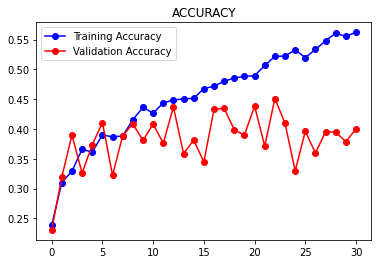

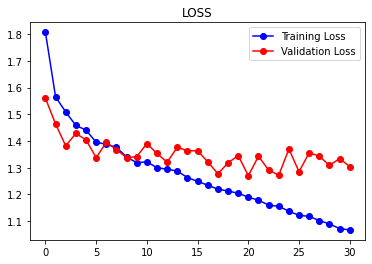

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
y_true_cat = np.argmax(y_true, -1)

536/536 [==============================] - 221s 389ms/step
Accuracy on Test Data: 53.62%
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     39533
           1       0.07      0.16      0.10      3762
           2       0.15      0.09      0.11      7861
           3       0.03      0.02      0.02      1214
           4       0.03      0.05      0.03      1206

    accuracy                           0.54     53576
   macro avg       0.20      0.20      0.20     53576
weighted avg       0.57      0.54      0.55     53576



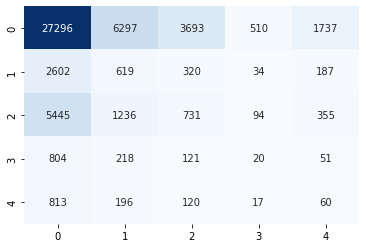

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = model.predict(test_dataset, batch_size = 512, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(y_true_cat, pred_Y_cat)*100))
print(classification_report(y_true_cat, pred_Y_cat))

import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_true_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

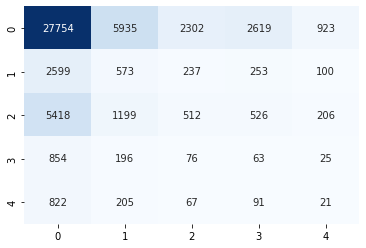

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_true_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)